In [1]:
import glob
import _init_paths
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect_hierarchy
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import caffe, os, sys, cv2
import argparse
from fast_rcnn.config import cfg, cfg_from_file, cfg_from_list
from datasets.config import CLASS_SETS

def _get_ann_file():
        prefix = 'image_info' 
        return os.path.join("/root/data/coco/", 'annotations',
                        prefix + '_' + "test2014" + '.json')

   

In [3]:
CLASSES_main = CLASS_SETS["coco"]
CLASSES_sub = CLASS_SETS['vehicle-types']



Loaded network ../models/hierarchy/v4/v4_iter_10000.caffemodel
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/data-NCTU_Highway_slow/images/set01/V000/set01_V000_472.jpg
(720, 1280, 3)
Detection took 0.115s for 200 object proposals
(200, 324)
(200, 81)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/data-NCTU_Highway_slow/images/set01/V000/set01_V000_1.jpg
(720, 1280, 3)
Detection took 0.083s for 200 object proposals
(200, 324)
(200, 81)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/data-NCTU_Highway_slow/images/set01/V000/set01_V000_300.jpg
(720, 1280, 3)
Detection took 0.060s for 200 object proposals
(200, 324)
(200, 81)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/data-NCTU_Highway_slow/images/set01/V000/set01_V000_201.jpg
(720, 1280, 3)
Detection took 0.064s for 200 object proposals
(200, 324)
(200, 81)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/data-NCTU_Highway_slow/images/set01

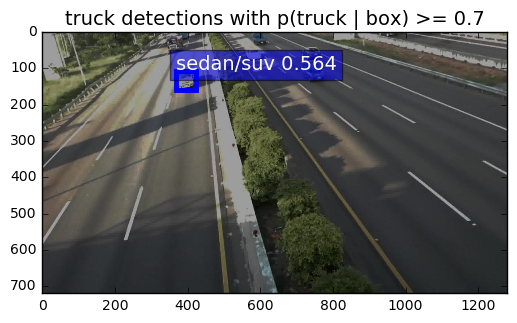

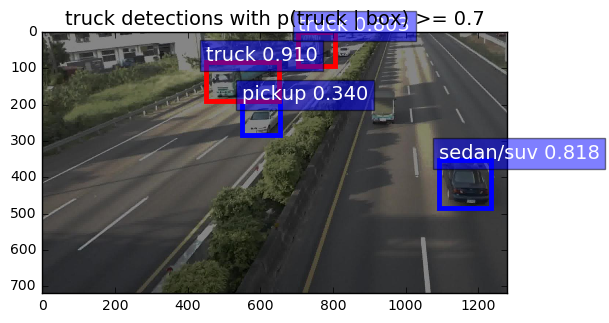

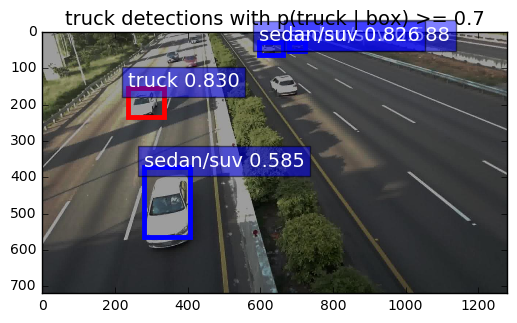

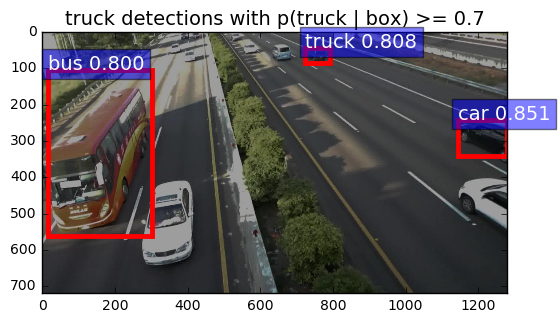

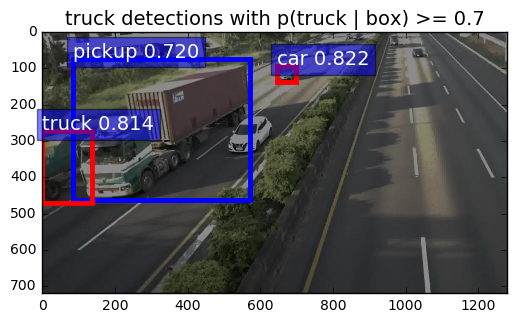

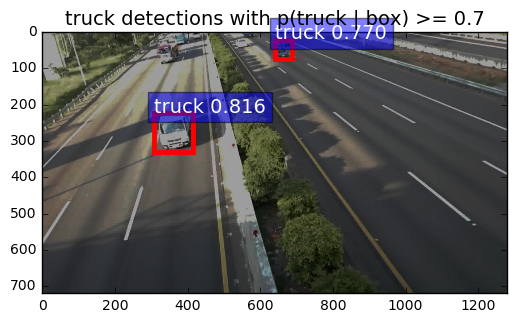

In [84]:
def get_sub_info(sub_scores, keeps, i):
    sub_ind = np.argmax(sub_scores[keeps][i])
    sub_score = sub_scores[keeps][i][sub_ind]
    sub_cls = CLASSES_sub[sub_ind]
    return sub_cls, sub_score, sub_ind

def vis_detections(im, class_names, dets_list, keeps_list, sub_scores, thresh=0.7):
    """Draw detected bounding boxes."""
    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(im, aspect='equal')
    
    for class_name, dets, keeps in zip(class_names, dets_list, keeps_list):

        inds = np.where(dets[:, -1] >= thresh)[0]
        if len(inds) == 0:
            continue


        for i in inds:
            bbox = dets[i, :4]
            score = dets[i, -1]
            sub_cls, sub_score, sub_ind = get_sub_info(sub_scores, keeps, i)
            #if sub_ind not in [1,2,3]:
                #continue
            edgecolor = "red"
            text = class_name
            confidence = score
            if (class_name == "car" or class_name == "truck") and sub_ind in [1,2,3]:
                text = sub_cls
                confidence = sub_score
                edgecolor = "blue"
                
            ax.add_patch(
                plt.Rectangle((bbox[0], bbox[1]),
                              bbox[2] - bbox[0],
                              bbox[3] - bbox[1], fill=False,
                              edgecolor=edgecolor, linewidth=3.5)
                )
            ax.text(bbox[0], bbox[1] - 2,
                    '{:s} {:.3f}'.format(text, confidence),
                    bbox=dict(facecolor='blue', alpha=0.5),
                    fontsize=14, color='white')

        ax.set_title(('{} detections with '
                      'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                      thresh),
                      fontsize=14)
    #plt.axis('off')
    #plt.tight_layout()
    #plt.draw()

def demo(net, im_file):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
   
    im = cv2.imread(im_file)
    print(im.shape)
    #int("Hallo")
    

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    _t = {'im_preproc': Timer(), 'im_net' : Timer(), 'im_postproc': Timer(), 'misc' : Timer()}
    scores, sub_scores,boxes = im_detect_hierarchy(net, im, _t)
    timer.toc()
    print ('Detection took {:.3f}s for '
           '{:d} object proposals').format(timer.total_time, boxes.shape[0])

    # Visualize detections for each class
    CONF_THRESH = 0.7
    NMS_THRESH = 0.3
    
    cls_list = []
    dets_list = []
    sub_cls_list = []
    keep_list = []
    print(boxes.shape)
    print(scores.shape)
    for cls_ind, cls in enumerate(CLASSES_main[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]    
        
        keep_list.append(keep)
        
        cls_list.append(cls)
        dets_list.append(dets)
        
        
        
        
    vis_detections(im, cls_list, dets_list,keep_list, sub_scores , thresh=CONF_THRESH)



if __name__ == '__main__':
    #cfg.TEST.HAS_RPN = True
   

    prototxt = "../models/pvanet/lite/hierachy/v1_test.prototxt"
    caffemodel = "../models/hierarchy/v4/v4_iter_10000.caffemodel"
    cfg_from_file("../models/pvanet/cfgs/submit_1019.yml")
    caffe.set_mode_gpu()
    caffe.set_device(0)
    cfg.GPU_ID = 0
    net = caffe.Net(prototxt, caffemodel, caffe.TEST)

    print '\n\nLoaded network {:s}'.format(caffemodel)

    # Warmup on a dummy image
    #m = 128 * np.ones((300, 500, 3), dtype=np.uint8)
    #for i in xrange(2):
        #_t = {'im_preproc': Timer(), 'im_net' : Timer(), 'im_postproc': Timer(), 'misc' : Timer()}
        #_, _= im_detect(net, im, _t)
    
    
    im_names = ['/root/data/data-NCTU_Highway_slow/images/set01/V000/set01_V000_472.jpg',\
               '/root/data/data-NCTU_Highway_slow/images/set01/V000/set01_V000_1.jpg',\
               '/root/data/data-NCTU_Highway_slow/images/set01/V000/set01_V000_300.jpg',\
               '/root/data/data-NCTU_Highway_slow/images/set01/V000/set01_V000_201.jpg',\
               '/root/data/data-NCTU_Highway_slow/images/set01/V000/set01_V000_104.jpg',\
               '/root/data/data-NCTU_Highway_slow/images/set01/V000/set01_V000_506.jpg',]
               

    
    #im_names += glob.glob("/root/data/demo/suitcase/*.jpg")
    #im_names = glob.glob("/root/data/demo/suitcase/*.jpg")

    for im_name in im_names:
        print '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
        print 'Demo for data/demo/{}'.format(im_name)
        demo(net, im_name)

    plt.show()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/Van/2017-09-14_141228.jpg
(467, 732, 3)
Detection took 0.048s for 200 object proposals
(200, 324)
(200, 81)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/Van/2017-09-14_141029.jpg
(513, 591, 3)
Detection took 0.033s for 200 object proposals
(200, 324)
(200, 81)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/Van/2017-09-14_141507.jpg
(525, 544, 3)
Detection took 0.031s for 200 object proposals
(200, 324)
(200, 81)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/Van/2017-09-14_141429.jpg
(488, 650, 3)
Detection took 0.041s for 200 object proposals
(200, 324)
(200, 81)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/Van/2017-09-14_141330.jpg
(498, 622, 3)
Detection took 0.032s for 200 object proposals
(200, 324)
(200, 81)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/Van/2017-09-14_141551.jpg
(488, 571, 3)
Detection took 0.032s fo

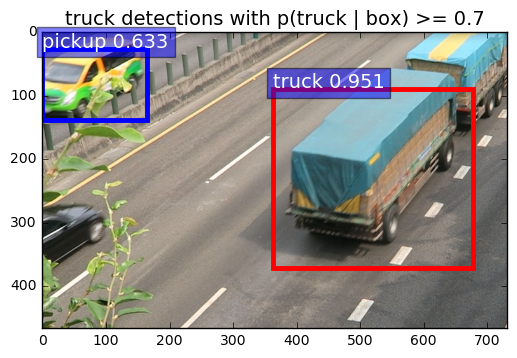

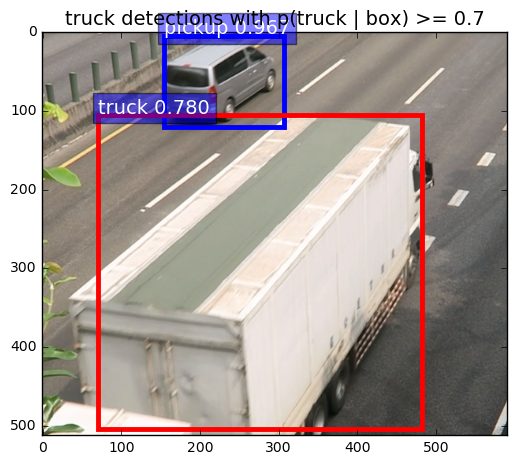

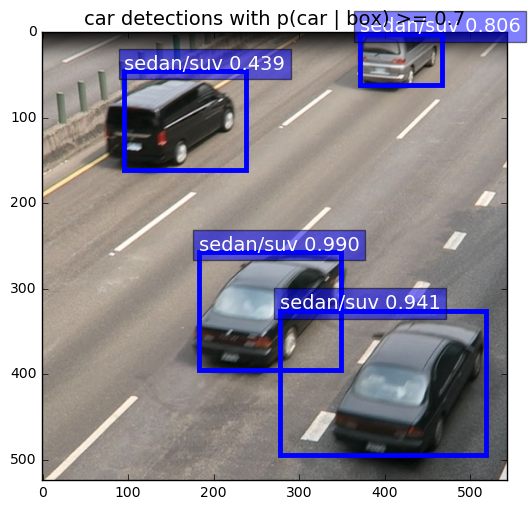

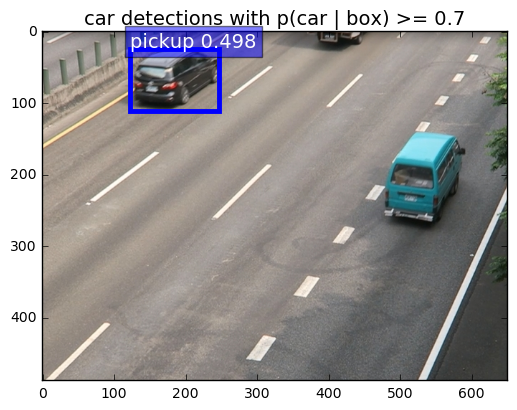

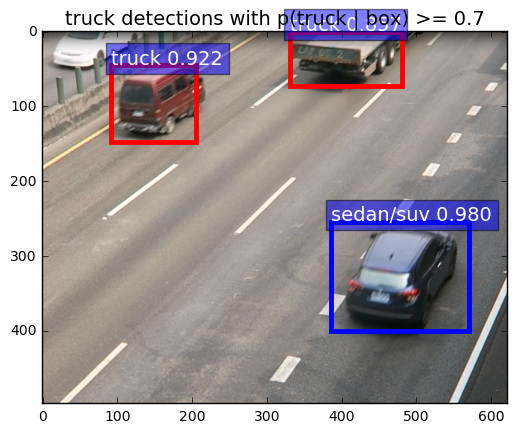

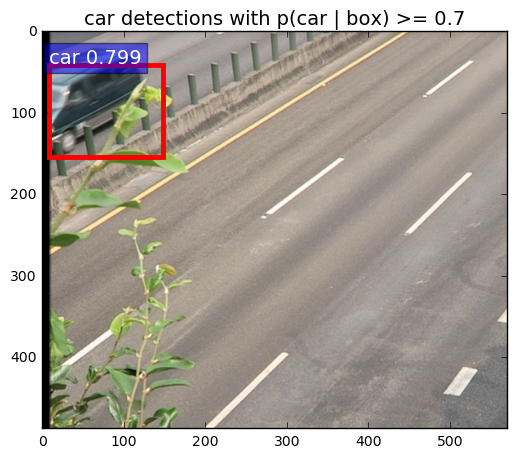

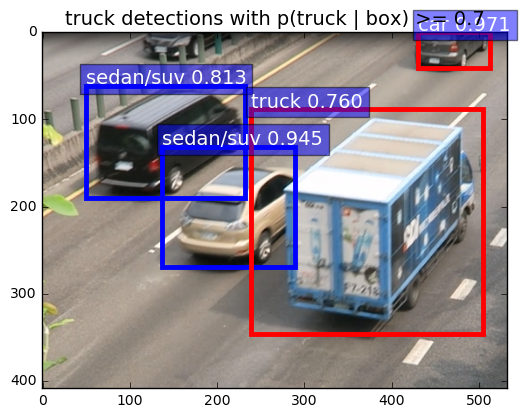

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


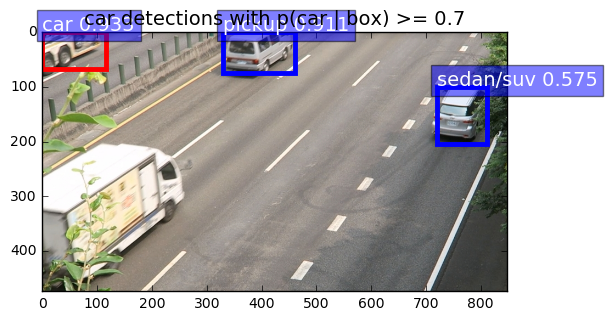

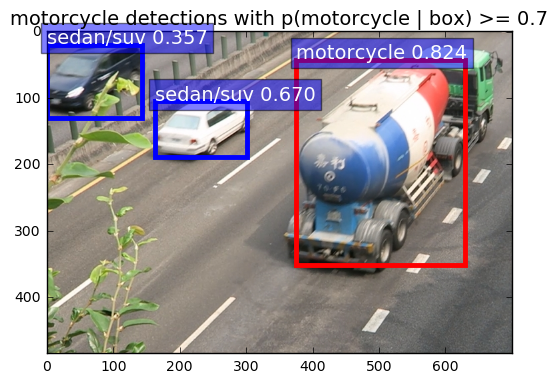

In [87]:
im_names = glob.glob("/root/data/Van/*.jpg")
for im_name in im_names:
    print '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
    print 'Demo for data/demo/{}'.format(im_name)
    demo(net, im_name)

plt.show()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/demo/van_big/2017-09-19_103513.jpg
(284, 712, 3)
Detection took 0.046s for 200 object proposals
(200, 324)
(200, 81)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/demo/van_big/2017-09-19_102821.jpg
(414, 947, 3)
Detection took 0.042s for 200 object proposals
(200, 324)
(200, 81)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/demo/van_big/2017-09-19_103559.jpg
(213, 643, 3)
Detection took 0.043s for 200 object proposals
(200, 324)
(200, 81)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/demo/van_big/6280517930_b590ea5169_b.jpg
(769, 1024, 3)
Detection took 0.045s for 200 object proposals
(200, 324)
(200, 81)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/demo/van_big/2017-09-19_104511.jpg
(361, 557, 3)
Detection took 0.031s for 200 object proposals
(200, 324)
(200, 81)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/demo/van_big

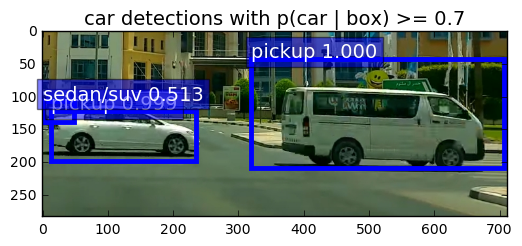

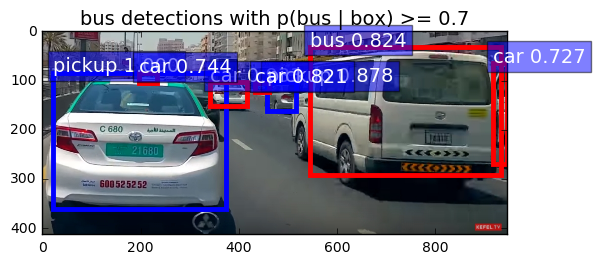

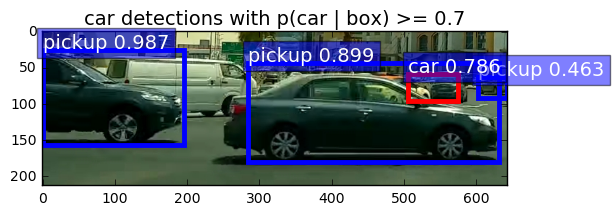

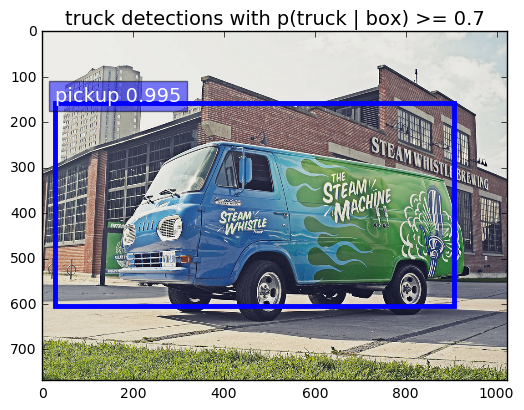

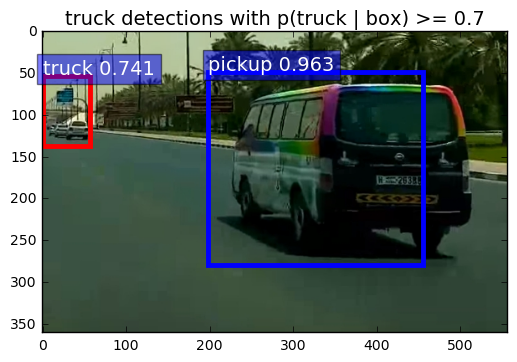

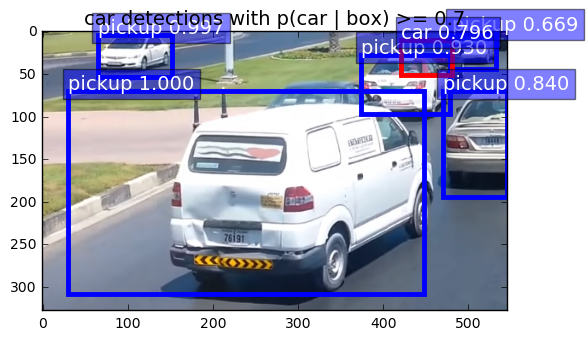

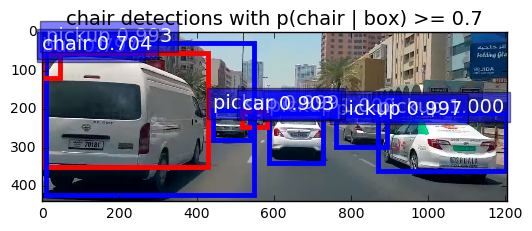

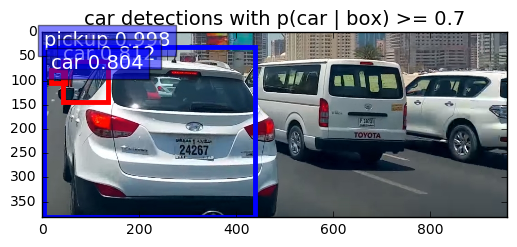

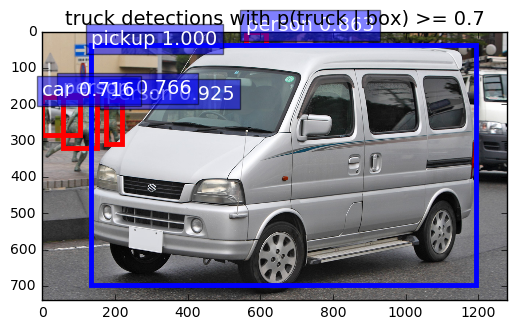

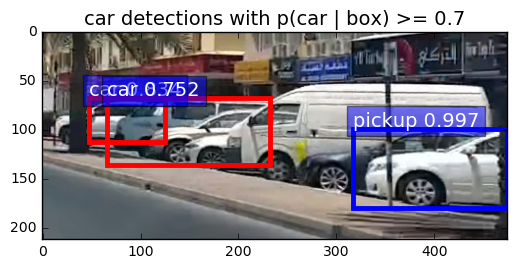

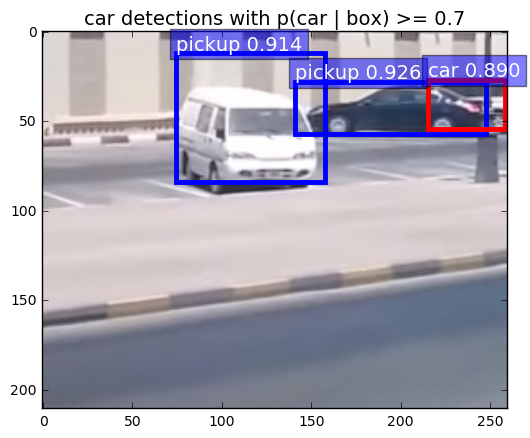

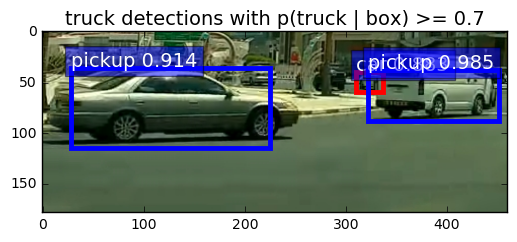

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


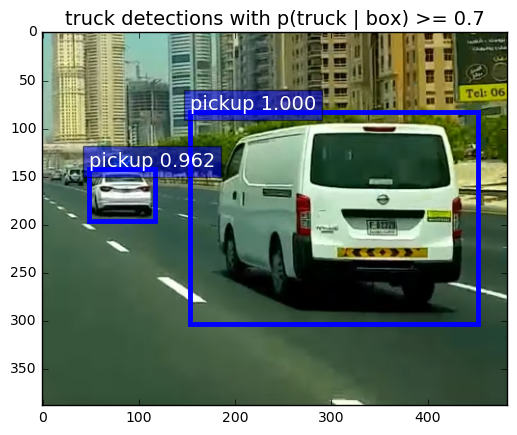

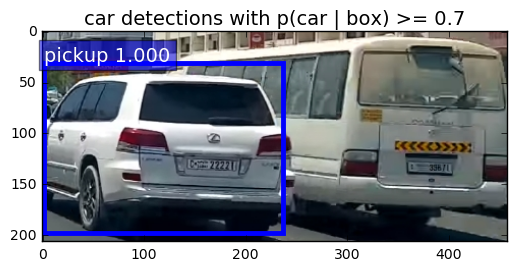

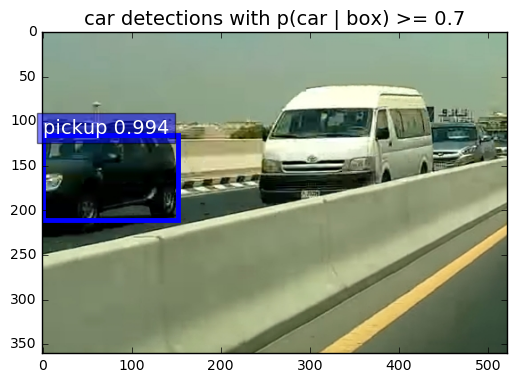

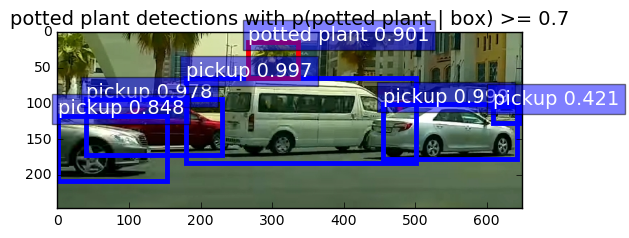

In [89]:
im_names = glob.glob("/root/data/demo/van_big/*.jpg")
for im_name in im_names:
    print '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
    print 'Demo for data/demo/{}'.format(im_name)
    demo(net, im_name)

plt.show()

In [12]:
x = np.array([[1,2,3],[4,5,6]])

In [29]:
x[:,-a].shape

(2, 1)

In [24]:
a = np.array([0,1,1], dtype=bool)

In [28]:
-a

array([ True, False, False], dtype=bool)

In [38]:
np.argmax(x, axis=1)

array([2, 2])

In [37]:
x

array([[1, 2, 3],
       [4, 5, 6]])

In [44]:
np.argmax(x[0,:])

2

In [78]:
mv /root/data/van_big /root/data/pickup_big /root/data/demo/